<a href="https://colab.research.google.com/github/zzhenxi/TIL/blob/main/%5BNLP%EB%B3%B5%EC%8A%B5%5D_%EC%96%B8%EC%96%B4%EB%AA%A8%EB%8D%B8%EA%B3%BC_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

전통적인 언어모델    
통계적 언어모델 :   
통계적 언어모델은 횟수 기반으로 확률을 계산하기 때문에 희소성 문제를 가짐    
1 times, 2 times는 있지만, 만약 말뭉치에 7 times가 없다면 7 times가 들어가는 문장을 만들 수 있을까? 만들 수 X! -> **희소성 문제**    


희소성 문제를 해결하기 위해    
1. n-gram 
2. back-off : n-gram의 n에 대해 n보다 작은 숫자를 적용해주는 방식    
예를 들어 I love twosomeplace cakes 라는 문장이 말뭉치에 나오지 않았다면, n을 단어수인 4이하로 설정해준다.
3. smoothing : 말뭉치에 등장하지 않는 단어에 대해 0대신 다른 값을 넣어줘서 등장 확률을 높여줌, 반대로 너무 많이 등장하는 단어에 대해서는 확률값을 좀 낮춰준다. 

RNN 구현

In [1]:
# 배웠던 RNN을 간단한 코드로 살펴보면 다음과 같습니다. 
import numpy as np

class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    # 필요한 가중치를 초기화하여 줍니다.
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b # 이 부분을 위의 그림과 연관지어 생각해보세요!
    h_next = np.tanh(t)

    self.cache = (x, h_prev, h_next)
    return h_next

LSTM을 이용한 텍스트 감성 분류 

In [2]:
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

# 파라미터를 설정합니다.
max_features = 20000 
maxlen = 80 # 한 문장 길이
batch_size = 32

# 데이터를 불러옵니다.
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
17473536/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences


In [3]:
# Sequence를 Padding 하여줍니다.
print('Pad Sequences (samples x maxlen)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

Pad Sequences (samples x maxlen)
x_train shape:  (25000, 80)
x_test shape:  (25000, 80)


In [4]:
x_train[0]

array([   15,   256,     4,     2,     7,  3766,     5,   723,    36,
          71,    43,   530,   476,    26,   400,   317,    46,     7,
           4, 12118,  1029,    13,   104,    88,     4,   381,    15,
         297,    98,    32,  2071,    56,    26,   141,     6,   194,
        7486,    18,     4,   226,    22,    21,   134,   476,    26,
         480,     5,   144,    30,  5535,    18,    51,    36,    28,
         224,    92,    25,   104,     4,   226,    65,    16,    38,
        1334,    88,    12,    16,   283,     5,    16,  4472,   113,
         103,    32,    15,    16,  5345,    19,   178,    32],
      dtype=int32)

In [9]:
import tensorflow as tf

# model을 정의합니다.
"""
keras의 기본 Embedding 벡터를 사용하였으며
LSTM 층에 dropout/recurrent_dropout을 적용하였습니다.
"""
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(max_features, 128), # Embedding Layer를 거친 후의 shape : (batch_size, maxlen, embedding_size=128) # 그냥 drop out : input에 대해 / recurrent drop out : 순환하고 있는 state에 대해 drop out
  tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2), # LSTM Layer를 거친 후의 shape : (batch_size, time_steps = 1, hidden_size(hidden_state의 차원?)=128) 
  # https://kimmisol.com/lstm-understanding-input-and-output-shapes-lstm-%EC%9E%85%EC%B6%9C%EB%A0%A5-shapes/ 참고 
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


lstm_1에서 output이 2D인 이유?    
return_sequence 가 false이기 때문에 (기본이 false임)

lstm의 입력은 항상 3D배열이고, 출력은 3D일수도, 2D일수도 있다. 

return_sequence가 False이면 출력은 2D 배열입니다. (batch_size, units)   
return_sequence가 True이면 출력은 3D 배열입니다. (batch_size, time_steps, units)



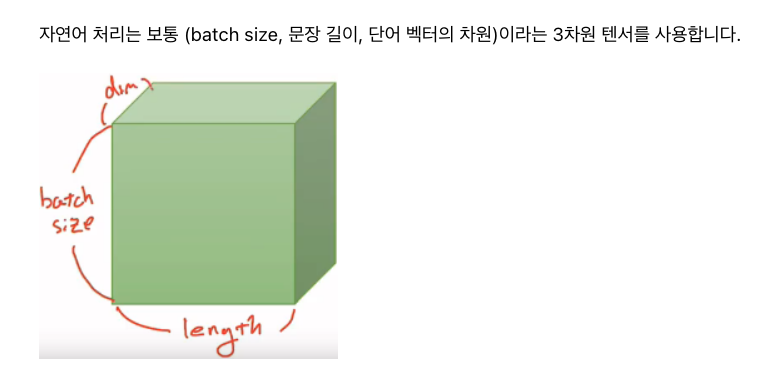

In [6]:
unicorns = model.fit(x_train, y_train,
          batch_size=batch_size, 
          epochs=3, 
          validation_data=(x_test,y_test))

Epoch 1/3
782/782 [==============================] - 251s 309ms/step - loss: 0.4288 - accuracy: 0.7985 - val_loss: 0.3614 - val_accuracy: 0.8408
Epoch 2/3
782/782 [==============================] - 240s 307ms/step - loss: 0.2544 - accuracy: 0.8974 - val_loss: 0.3858 - val_accuracy: 0.8375
Epoch 3/3
782/782 [==============================] - 240s 307ms/step - loss: 0.1598 - accuracy: 0.9408 - val_loss: 0.4408 - val_accuracy: 0.8304


여기서 잠깐!    
lstm으로 감정분류를 한 것, 그리고 cnn으로 감정분류를 한 것중에 속도가 높은 것은 무엇일까?   
lstm은 순환신경망을 근간으로 하는 모델이다. 따라서 병렬처리가 되지 않아 학습 속도가 느릴 수 밖에 없고, (한번 학습하는데 왔다,,,갔다,,, 하려면 시간이 매우 오래걸림..)   
cnn으로, 그러니깐 MLP(다층 퍼셉트론)으로 학습을 하면 병렬처리가 가능하기 때문에 lstm보다 학습 속도가 빠를 것이다. 


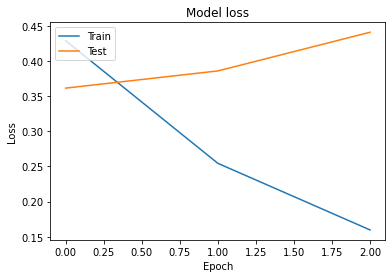

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(unicorns.history['loss'])
plt.plot(unicorns.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();


train이 과적합되지 않고, test loss가 확 늘어나지 않는 그 시점이 바로 적절한 하이퍼 파라미터값이 된다.

Attention

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
# 데이터셋을 다운로드합니다.
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2654208/2638744 [==============================] - 0s 0us/step


In [3]:
# 유니코드 파일을 아스키코드로 변환하는 함수입니다.
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                 if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [4]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [5]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in line.split('\t')]
                for line in lines[:num_examples]]

  return zip(*word_pairs)

In [6]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [7]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [8]:
# 2개 언어이기 때문에, tokenizer가 각각의 언어별로 따로 필요합니다.
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [9]:
# load할 dataset의 개수를 30000으로 설정
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# target과 input의 최대 길이 구하기(문장 최대 길이)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]


In [10]:
# 8:2 비율로 train-test split 진행
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 데이터 개수 뽑아보기
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [11]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

# tf.data.Dataset -> 텐서플로우에서 제공하는 Dataset 클래스입니다.
# Dataset 클래스는 배치 구성, 데이터셋 셔플, 윈도우 구현, 변환 함수 적용 등 다양한 기능을 제공합니다.
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [12]:
# 첫 번째 배치 뽑아보기
# input_batch의 경우, 총 64개 데이터로 이루어져 있고, 1개 문장이 16개 단어로 이루어져 있습니다.
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [13]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    # |x| = (batch_sz, seq_len)
    x = self.embedding(x) # |x| = (batch_sz, seq_len, embedding_dim)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [14]:
# sample input을 통해 Encoder 레이어 결과값의 shape을 확인해보겠습니다
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [15]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    # W1(query_with_time_axis) == (batch_size, 1, units)
    # W2(values) == (batch_size, max_len, units)
    # W1(query_with_time_axis) + W2(values) == (batch_size, max_len, units)
    # V(tf.nn.tanh(W1(query_with_time_axis) + W2(values))) == (batch_size, max_len, 1)

    attention_weights = tf.nn.softmax(score, axis=1) # attention_weights == (batch_size, max_length, 1)

    context_vector = attention_weights * values # context_vector == (batch_size, max_len, hidden_size)
    context_vector = tf.reduce_sum(context_vector, axis=1) # context_vector == (batch_size, hidden_size)

    return context_vector, attention_weights

In [16]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units)", attention_result.shape)
print("Attention weights shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [17]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # x == (batch_size, 1)
    # hidden == (batch_size, hidden_size)
    # enc_output shape == (batch_size, max_length, hidden_size)

    context_vector, attention_weights = self.attention(hidden, enc_output)
    # context_vector == (batch_size, hidden_size)
    # attention_weights == (batch_size, max_length, 1)

    x = self.embedding(x) # x == (batch_size, 1, embedding_dim)

    # tf.expand_dims(context_vector, 1) == (batch_size, 1, hidden_size)
    # tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) == (batch_size, 1, embedding_dim+hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    # output == (batch_size, 1, hidden_size)
    # state == (batch_size, hidden_size)
    output, state = self.gru(x)

    
    output = tf.reshape(output, (-1, output.shape[2])) # output  == (batch_size * 1, hidden_size)

    x = self.fc(output) # x == (batch_size, vocab)

    return x, state, attention_weights

In [18]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

Decoder output shape: (batch_size, vocab size) (64, 4935)


In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [20]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [21]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
      
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.4336
Epoch 1 Batch 100 Loss 2.0694
Epoch 1 Batch 200 Loss 1.7620
Epoch 1 Batch 300 Loss 1.6472
Epoch 1 Loss 2.0180
Time taken for 1 epoch 1521.9355187416077 sec

Epoch 2 Batch 0 Loss 1.5174
Epoch 2 Batch 100 Loss 1.5189
Epoch 2 Batch 200 Loss 1.3357
Epoch 2 Batch 300 Loss 1.2212
Epoch 2 Loss 1.3716
Time taken for 1 epoch 1461.9285283088684 sec

Epoch 3 Batch 0 Loss 1.0207
Epoch 3 Batch 100 Loss 1.0671
Epoch 3 Batch 200 Loss 0.9667
Epoch 3 Batch 300 Loss 0.8822
Epoch 3 Loss 0.9540
Time taken for 1 epoch 1454.7358787059784 sec

Epoch 4 Batch 0 Loss 0.7086
Epoch 4 Batch 100 Loss 0.7323
Epoch 4 Batch 200 Loss 0.6572
Epoch 4 Batch 300 Loss 0.6179
Epoch 4 Loss 0.6383
Time taken for 1 epoch 1438.5500259399414 sec

Epoch 5 Batch 0 Loss 0.4772
Epoch 5 Batch 100 Loss 0.4837
Epoch 5 Batch 200 Loss 0.4597
Epoch 5 Batch 300 Loss 0.4983
Epoch 5 Loss 0.4266
Time taken for 1 epoch 1430.166311264038 sec

Epoch 6 Batch 0 Loss 0.2928
Epoch 6 Batch 100 Loss 0.3116
Epoch 6 Batch 200 

KeyboardInterrupt: ignored

In [22]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [23]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [24]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


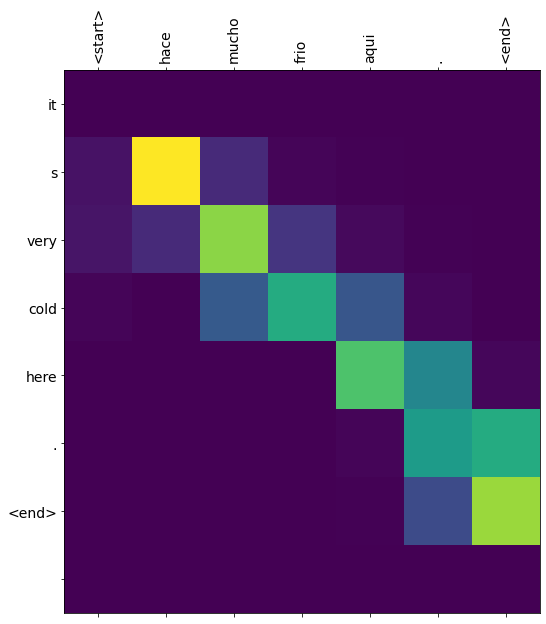

In [25]:
translate(u'hace mucho frio aqui.')


Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


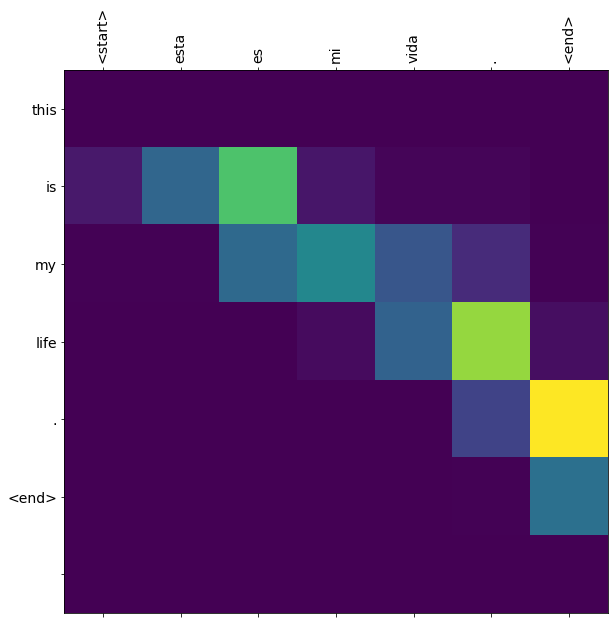

In [26]:
translate(u'esta es mi vida.')